### HERE WE TRAIN THE MODELS FOR OUR OUTLIERS CLUSSIFICATION
#### LIST OF MODELS THAT WE'LL USE:

1. Isolation Forest
2. Random Forest
3. XGBoost
4. KNN

#### Objective of the Code

In this code the models are trained on a specific dataset by identifying the best hyperparameters for each model, having used multiple models in the end these models will be input to a final model which has the aim of mediating the classification of the individual models with the intent to create a final model that is more robust to changes in the dataset.

With the intention of subsequently combining multiple datasets by applying the Bagging methodology (see the file interpretability)

#### Sequence of instructions:

1. A specific dataset processed by the preprocessing script is loaded by processing the original data. The data set you want to load can be chosen using the variable dataset_name

2. The dataset is divided into trainset and testset with a balance of 20% for the testset, maintaining, since the aim is to classify the outliers, the proportion of anomalous and normal for each portion of the dataset

3. For each model, training is done first with the trainset and then evaluated using the testset, paying particular attention to the f1_score

4. To optimize the parameters, the Bayesian optimization function was used which allows us to identify the values ​​of the hyperparameters by trying to reconstruct a probability density distribution that links the hyperparameters with the value of the f1_score. In our case it has the aim of finding those parameters which in the cross_validation done in the trainset find the best hyperparameters that maximize the f1_score

5. Finally, two voting models are created: deep_learning and based on the weight of the f1_score. In particular, the output of the final model is the probability that the classified value is an outlier

#### Main considerations

We opted to use the f1_score as a method of measuring the goodness of the model, as the F1 score is particularly useful when working with unbalanced datasets, where one class is much more frequent than the other. In fact, looking only at the accuracy does not truly represent the goodness of the model. For example, it can happen to have a high accuracy simply by always predicting the majority class.

In [49]:
# import of libraries for displaying results and supporting functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# This library was built by us to support the execution of this code
from tools import add_sheet_to_excel, add_data_to_sheet, extract_data_model, save_columns_settings, save_feature_settings, save_score_settings, save_voting_scores_settings

from sklearn.model_selection import train_test_split

In [50]:
# Path where we can find the data file
file_path = './FinancialMarketData.xlsx'
# The file in which the hyperparameters and evaluations of previously done training models were saved to minimize training time
file_settings = './settings_models.json'
# Name of the dataset that we want to use for the following training
# Values ​​that the variable dataset_name accepts are: STATIONARITY, RESIDUAL, SPREAD, DIFF_TIME, EWS
dataset_name = 'EWS'
# If True, for each model that requires hyperparameters, the saved settings of the various models will be loaded from previous training
# Otherwise, each model will be trained by searching for the best hyperparameters from scratch 

# WE RECOMMEND LEAVING THIS FLAG AT TRUE SO THE BEST PARAMETERS ARE LOADED FROM 
# THE SETTINGS FILE TO AVOID THE TRAINING TIME WHICH WOULD TAKE SEVERAL DOZENS OF MINUTES
load_params_from_setting = True
total_score = []
# Here we define what type of measurement we use to identify the quality of the model
valutation_score = "f1_score"

# loading of the data from the excel file
data = pd.read_excel(file_path, sheet_name=dataset_name)
# Separation of feature from label
flag = data['Y'].values
date =  data['Data'].values
data = data.drop(['Data', 'Y'], axis=1)
data = pd.DataFrame(data)


# Save the columns of the dataset in the settings file json
all_columns = data.columns.tolist()
save_columns_settings(file_settings, all_columns, dataset_name)

data.head()

,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,VIX,USGG30YR,...,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
0,283.25,0.077,1388,157.26,100.56,105.86,1.6460,25.77,22.50,6.671,...,116.4635,230.5267,123.7616,1416.12,127.75,990.59,856.76,224.33,217.34,34.30
1,287.65,0.043,1405,165.01,101.86,105.47,1.6383,28.85,21.50,6.747,...,117.2674,231.3770,123.7616,1428.79,129.50,993.98,925.22,234.37,227.08,32.74
2,287.15,0.135,1368,167.24,102.41,106.04,1.6496,28.28,23.02,6.634,...,117.9946,232.3895,123.7616,1385.93,126.48,974.83,886.93,216.82,233.00,32.46
3,282.75,0.191,1311,166.85,104.92,107.85,1.6106,28.22,23.45,6.423,...,120.5100,231.9417,122.3281,1385.31,129.19,1007.12,842.60,201.89,237.48,31.29
4,298.40,0.312,1277,165.43,104.22,109.30,1.6108,28.02,21.25,6.231,...,118.7914,237.8117,122.3281,1411.95,134.67,1034.58,945.15,218.00,258.02,31.32


In [51]:
# here we count the number of anomalies to identify the percentage of anomalies compared to the total observations. 
# This metric will be useful as a hyperparameter to balance the prediction of the models well since we are dealing 
# with an unbalanced dataset
num_ones = np.count_nonzero(flag == 1)
contamination = num_ones  / flag.shape[0]
print("contamination: ", contamination)

# CREATION OF THE DATASET FOR THE TRAINING AND THE TEST 
# 20% is test set and with stratify=flag with this we are sure that the ratio of anomalies in the various datasets is maintained 
X_train, X_test, y_train, y_test = train_test_split(data, flag, test_size=0.2, stratify=flag, random_state=79)

contamination:  0.21332133213321333


In [52]:
# imports library for the models and the scoring of the models
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, roc_auc_score, auc, confusion_matrix, make_scorer
from hyperopt import hp
from scipy.special import expit


Accuracy: 0.7713004484304933
Precision: 0.46511627906976744
Recall: 0.4166666666666667
F1-score: 0.43956043956043955
ROC AUC: 0.6426190476190476


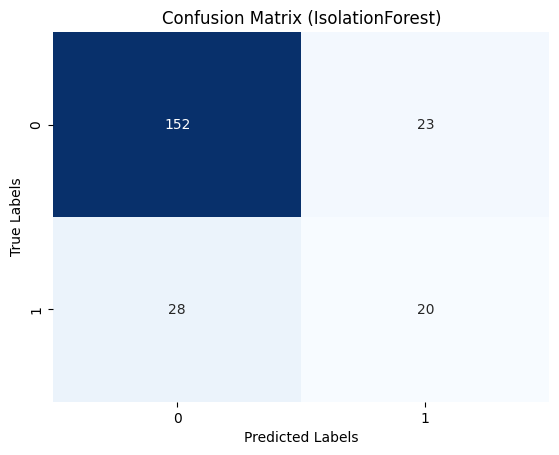

In [53]:
# First model is the Isolation Forest
# we use it beacuse in general it is specialized in the outliers detection
isolation_forest = IsolationForest(n_estimators=200, bootstrap=True, contamination=contamination)
isolation_forest.fit(X_train)
# Here we have in output the probability that the input is an anomaly data
anomaly_scores_isolation = isolation_forest.decision_function(X_test)
anomaly_labels_isolation = isolation_forest.predict(X_test)

anomaly_labels_isolation = [1 if pred == -1 else 0 for pred in anomaly_labels_isolation ]

score_isolation_forest = {}

# MODEL EVALUTATION
score_isolation_forest["accuracy"] = accuracy_score(y_test, anomaly_labels_isolation)
score_isolation_forest["precision"] = precision_score(y_test, anomaly_labels_isolation)
score_isolation_forest["recall"] = recall_score(y_test, anomaly_labels_isolation)
score_isolation_forest["f1_score"] = f1_score(y_test, anomaly_labels_isolation)
score_isolation_forest["roc_auc"] = roc_auc_score(y_test, anomaly_labels_isolation)

print("Accuracy:", score_isolation_forest["accuracy"])
print("Precision:", score_isolation_forest["precision"])
print("Recall:", score_isolation_forest["recall"])
print("F1-score:", score_isolation_forest["f1_score"])
print("ROC AUC:", score_isolation_forest["roc_auc"])

# confusion matrix
conf_matrix_test = confusion_matrix(y_test, anomaly_labels_isolation)

plt.figure()
sns.heatmap(conf_matrix_test, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (IsolationForest)')
plt.show()

# Here we append the value of the f1_score to the array of scores in order to compite the weights for the final voting algorithm
total_score.append(score_isolation_forest[valutation_score])
# Save the evaluation scores of the model in the settings file json for this dataset
save_score_settings(file_settings, score_isolation_forest, dataset_name, "isolation_forest")

# In general our goal is to maximize the f1 score with the combined use of multiple models 

In [54]:
# The second model is the Random Forest
# We also use it beacuse rappresents one of the best robost model for the classification that is based on the trees
# Here we have used the Bayesian Optimization in order to identify the best hyperparameters of the model

# Here we have written the function to call during the Bayesian Optimization in which we define the score to maximize
# This function requires as parameters the main hyperparameters of the random forest
def objective(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, bootstrap):
    bootstrap = bool(round(bootstrap))
    max_features = max(1, int(round(max_features)))
    
    random_forest_model = RandomForestClassifier(
        # we use the contamination in order to define the ratio between anomalies and normal data
        class_weight={0: (1-contamination), 1: contamination}, 
        random_state=79,
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        max_features=max_features,
        bootstrap=bootstrap,
    )
    
    # Also we use the cross_validation to identify the hyperparameter avoiding the overfitting of the model
    # beacuse the coress_validation as the aim to simulate the simulate the behavior of the model in the presence of new data 
    # by pointing out the normal variance of the dataset (of this problem)
    score = cross_val_score(random_forest_model, X_train, y_train, cv=4, scoring='f1_macro').mean()
    return score

# Define the hyperparameter space
# We use the range of the normal values of this kind of parameters
pbounds = {
    'n_estimators': (200, 600),
    'max_depth': (20, 60),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10),
    'max_features': (1, len(X_train.columns)/3),
    'bootstrap': (0, 0.5)
}

params_random_forest = {}

# Here to avoid training the model we can load the best values for this model that have been identified 
# by successful training, otherwise the model would require an average of 15 minutes to train 
if not load_params_from_setting:
    # Run Bayesian Optimization
    optimizer_random_forest = BayesianOptimization(f=objective, pbounds=pbounds, random_state=42)
    optimizer_random_forest.maximize(init_points=10, n_iter=50)

    # Print the best hyperparameters found
    print("Better hyperparameters:")
    print(optimizer_random_forest.max)
    params_random_forest = optimizer_random_forest.max["params"]
else:
    # or we can load the params form the settings file
    params_random_forest = extract_data_model(file_settings,dataset_name, "random_forest", "params")["params"]


Accuracy: 0.9103139013452914
Precision: 0.7692307692307693
Recall: 0.8333333333333334
F1-score: 0.8
ROC AUC: 0.8823809523809524


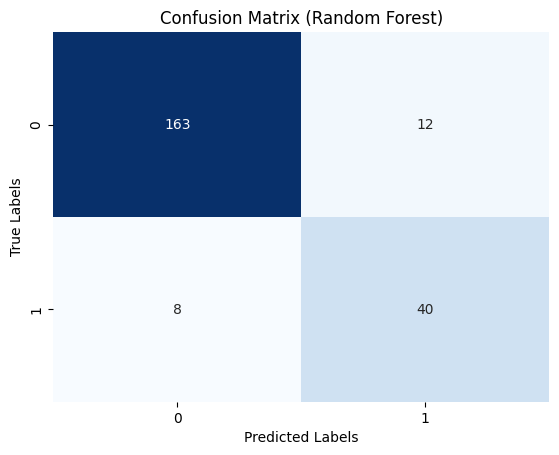

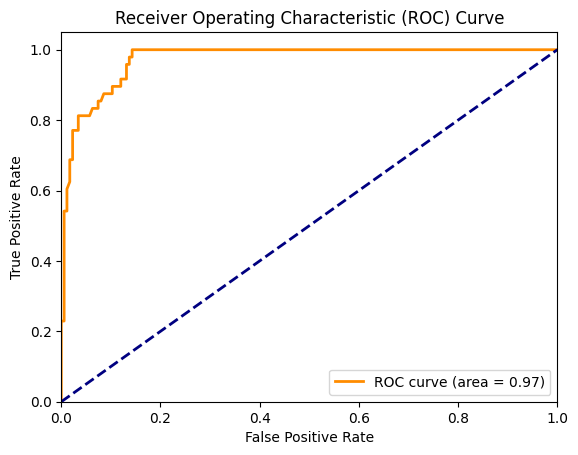

In [55]:
# Here this code as the aim to test the model with the previous hyperparameters in the test set
random_forest_model = RandomForestClassifier(
        class_weight={0: (1-contamination), 1: contamination}, 
        random_state=79,
        n_estimators=int(params_random_forest["n_estimators"]),
        max_depth=int(params_random_forest["max_depth"]),
        min_samples_split=int(params_random_forest["min_samples_split"]),
        min_samples_leaf=int(params_random_forest["min_samples_leaf"]),
        max_features=int(params_random_forest["max_features"]),
        bootstrap=(True if params_random_forest["bootstrap"] else False),
    )

# training of the model
random_forest_model.fit(X_train, y_train)
anomaly_predictions_random = random_forest_model.predict(X_test)
 
score_random_forest = {}

# Here we identify the valuation of the model
score_random_forest["accuracy"] = accuracy_score(y_test, anomaly_predictions_random)
score_random_forest["precision"] = precision_score(y_test, anomaly_predictions_random)
score_random_forest["recall"] = recall_score(y_test, anomaly_predictions_random)
score_random_forest["f1_score"] = f1_score(y_test, anomaly_predictions_random)
score_random_forest["roc_auc"] = roc_auc_score(y_test, anomaly_predictions_random)

print("Accuracy:", score_random_forest["accuracy"])
print("Precision:", score_random_forest["precision"])
print("Recall:", score_random_forest["recall"])
print("F1-score:", score_random_forest["f1_score"])
print("ROC AUC:", score_random_forest["roc_auc"])

# confusion matrix

conf_matrix_test = confusion_matrix(y_test, anomaly_predictions_random)

plt.figure()
sns.heatmap(conf_matrix_test, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

# ROC curve and AUC

probs_random = random_forest_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs_random)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Here we update with the RandomForestClassifier's f1_score
total_score.append(score_random_forest[valutation_score])
# Furthermore, we want to identify which features were actually used for the classification and their weights for each of them
weights_feature_random_forest = random_forest_model.feature_importances_
# We save the settings and scores of this model in the settings file json
save_feature_settings(file_settings, weights_feature_random_forest, dataset_name, "random_forest")
save_score_settings(file_settings, score_random_forest, dataset_name, "random_forest")

In [56]:
# The third model is the Random XGBClassifier
# We also chose XGBClassifier as it uses gradient boosting, a technique that builds the model by combining several weak trees (typically decision trees) in sequential mode. 
# Each subsequent tree tries to correct the errors of the previous one, iteratively improving the model's performance.
def objective(n_estimators, learning_rate, max_depth, subsample, colsample_bytree):

    xgboost_forest_model = XGBClassifier(
        n_estimators=int(n_estimators),
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    
    score = cross_val_score(xgboost_forest_model, X_train, y_train, cv=4, scoring='f1_macro').mean()
    return score 

# Define the hyperparameter space
# We use the range of the normal values of this kind of parameters
pbounds = {
    'n_estimators': (100, 1000),
    'learning_rate': (0.01, 0.3),
    'max_depth': (3, 10),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0)
}

params_xgboost = {}

# Also here the same as before
if not load_params_from_setting:

    optimizer_xgboost = BayesianOptimization(f=objective, pbounds=pbounds, random_state=42)
    optimizer_xgboost.maximize(init_points=10, n_iter=50)

    print("Migliori iperparametri:")
    print(optimizer_xgboost.max)
    params_xgboost  = optimizer_xgboost.max["params"]

else:
    params_xgboost = extract_data_model(file_settings,dataset_name, "xgboost", "params")["params"]

Accuracy: 0.905829596412556
Precision: 0.7454545454545455
Recall: 0.8541666666666666
F1-score: 0.7961165048543689
ROC AUC: 0.8870833333333333


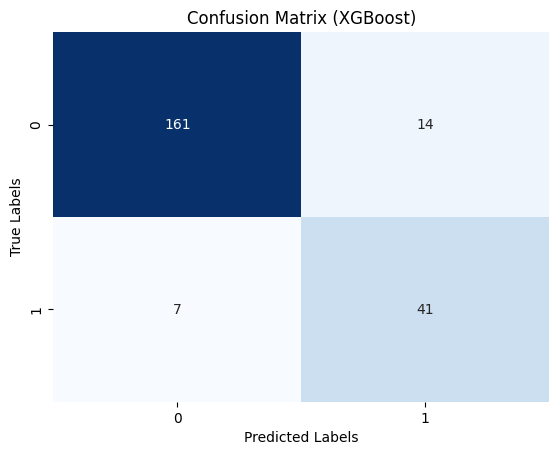

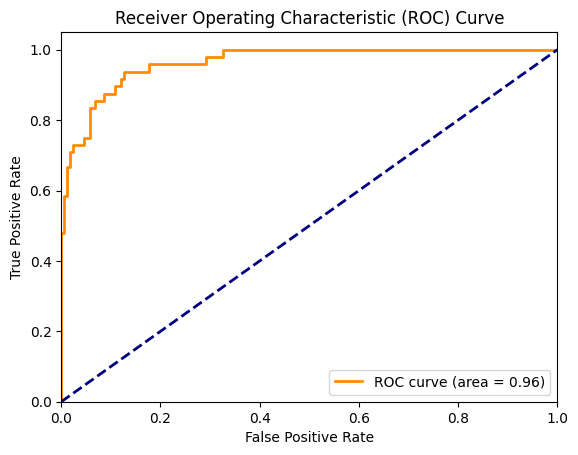

In [57]:
# Here this code as the aim to test the model with the previous hyperparameters in the test set
xgboost_forest_model = XGBClassifier(
        n_estimators=int(params_xgboost["n_estimators"]),
        learning_rate=params_xgboost["learning_rate"],
        max_depth=int(params_xgboost["max_depth"]),
        subsample=params_xgboost["subsample"],
        colsample_bytree=params_xgboost["colsample_bytree"],
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

# Fit the model with our train set
xgboost_forest_model.fit(X_train, y_train)
anomaly_predictions_xgboost = xgboost_forest_model.predict(X_test)

score_xgboost = {}

score_xgboost["accuracy"] = accuracy_score(y_test, anomaly_predictions_xgboost)
score_xgboost["precision"] = precision_score(y_test, anomaly_predictions_xgboost)
score_xgboost["recall"] = recall_score(y_test, anomaly_predictions_xgboost)
score_xgboost["f1_score"] = f1_score(y_test, anomaly_predictions_xgboost)
score_xgboost["roc_auc"] = roc_auc_score(y_test, anomaly_predictions_xgboost)

print("Accuracy:", score_xgboost["accuracy"])
print("Precision:", score_xgboost["precision"])
print("Recall:", score_xgboost["recall"])
print("F1-score:", score_xgboost["f1_score"])
print("ROC AUC:", score_xgboost["roc_auc"])

# confusion matrix

conf_matrix_test = confusion_matrix(y_test, anomaly_predictions_xgboost)

plt.figure()
sns.heatmap(conf_matrix_test, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (XGBoost)')
plt.show()

# ROC curve and AUC

probs_xgboost = xgboost_forest_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs_xgboost)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# The save ad before about saving the state of the model's hyperparameters
total_score.append(score_xgboost[valutation_score])
# We also save which feature was actually used and in what weights
weights_feature_xgboost = xgboost_forest_model.feature_importances_
save_feature_settings(file_settings, weights_feature_xgboost, dataset_name, "xgboost")
save_score_settings(file_settings, score_xgboost, dataset_name, "xgboost")

In [58]:
params_knn = {}

# Evaluation function for Bayesian optimization
def knn_crossval(n_neighbors, leaf_size, p):
    # Creation of the KNN model with the specified parameters
    model = KNeighborsClassifier(
        n_neighbors=int(n_neighbors),
        leaf_size=int(leaf_size),
        p=int(p)
    )
    # cross-validation to evaluate the model
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
    # Return the mean f1_score
    return scores.mean()

# Define the search space for the hyperparameters
pbounds = {
    'n_neighbors': (1, 20),
    'leaf_size': (20, 40),
    'p': (1, 2)
}

# If you want to start the training, set load_params_from_setting to False but the training 
# would take several tens of minutes
if not load_params_from_setting:
    optimizer = BayesianOptimization(
        f=knn_crossval,
        pbounds=pbounds,
        random_state=1,
        allow_duplicate_points=True
    )

    # Run the optimization
    optimizer.maximize(
        init_points=10, 
        n_iter=50      
    )

    print(optimizer.max)

    params_knn = optimizer.max["params"]

else:
    # We load the best hyperparameters from the settings_models file that we saved after the first training
    params_knn = extract_data_model(file_settings,dataset_name, "knn", "params")["params"]


Accuracy: 0.9013452914798207
Precision: 0.7321428571428571
Recall: 0.8541666666666666
F1-score: 0.7884615384615384
ROC AUC: 0.8842261904761903


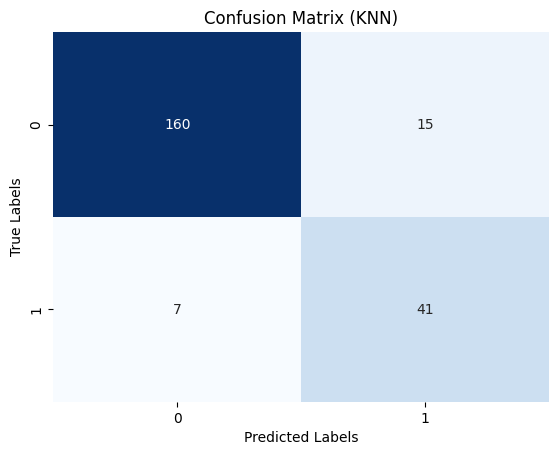

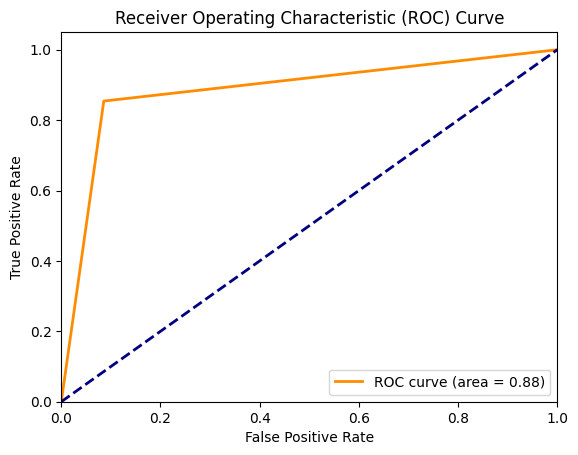

In [59]:
# Here this code as the aim to test the model with the previous hyperparameters in the test set
knn_model =KNeighborsClassifier(
        n_neighbors=int(params_knn["n_neighbors"]),
        leaf_size=int(params_knn["leaf_size"]),
        p=int(params_knn["p"])
    )

# Fit the model with our train set
knn_model.fit(X_train, y_train)
anomaly_predictions_knn = knn_model.predict(X_test)

score_knn = {}

score_knn["accuracy"] = accuracy_score(y_test, anomaly_predictions_knn)
score_knn["precision"] = precision_score(y_test, anomaly_predictions_knn)
score_knn["recall"] = recall_score(y_test, anomaly_predictions_knn)
score_knn["f1_score"] = f1_score(y_test, anomaly_predictions_knn)
score_knn["roc_auc"] = roc_auc_score(y_test, anomaly_predictions_knn)

print("Accuracy:", score_knn["accuracy"])
print("Precision:", score_knn["precision"])
print("Recall:", score_knn["recall"])
print("F1-score:", score_knn["f1_score"])
print("ROC AUC:", score_knn["roc_auc"])

# confusion matrix

conf_matrix_test = confusion_matrix(y_test, anomaly_predictions_knn)

plt.figure()
sns.heatmap(conf_matrix_test, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (KNN)')
plt.show()

# ROC curve and AUC

probs_knn = knn_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs_knn)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# The save ad before about saving the state of the model's hyperparameters
total_score.append(score_knn[valutation_score])
save_score_settings(file_settings, score_knn, dataset_name, "knn")

In [61]:
# Here the aim is to save the classification probabilities of each model in the basic Excel used as an internal database
# This stage is useful for the voting algorithm as it will be the inputs to the voting model
data_prediction = {}

data_prediction["isolation_forest"] = isolation_forest.decision_function(data)
data_prediction["random_forest_model"] = random_forest_model.predict_proba(data)[:, 1]
data_prediction["xgboost_forest_model"] = xgboost_forest_model.predict_proba(data)[:, 1]
data_prediction["knn"] = knn_model.predict_proba(data)[:, 1]

data_prediction = pd.DataFrame(data_prediction)
data_prediction.head()

# save in the excel file
# add_sheet_to_excel(file_path, 'MODELS')
# add_data_to_sheet(file_path, 'MODELS', data_prediction)

The file './FinancialMarketData.xlsx' exists. I add a new sheet.
Sheet 'MODELS' already exists.
File saved as './FinancialMarketData.xlsx'.
Data added and file saved as './FinancialMarketData.xlsx'.
